In [2]:
import torch
from torch.utils.data import DataLoader
import voc12.dataloader
from misc import pyutils, torchutils, indexing
import importlib
from tqdm import tqdm
import cv2
import numpy as np
import os
from utility import image_util, util

In [3]:
infer_list = "voc12/val.txt"
voc12_root ="../Dataset/VOC2012/"
depth_root = "../result/depth_img/"
cam_root = "../irn_result/cam"

beta = 5
exp_times = 10

device = 'cuda:0'

In [4]:
dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(infer_list,
                                                             voc12_root=voc12_root,
                                                             scales=(1.0,))

In [8]:
data_loader = DataLoader(dataset, shuffle=False)

with torch.no_grad():
    pack = next(iter(data_loader))
    name = pack['name'][0]
    
    org_img_size = np.asarray(pack['size'])
    depth_map = image_util.read_image(os.path.join(depth_root, name+'.png'))
    
    edge_map = util.depth_to_edge(depth_map)
    edge_map = util.normalize(edge_map)
    edge_map = torch.from_numpy(edge_map)
    edge_map = edge_map.unsqueeze(0)
    
    cam_dict = np.load(os.path.join(cam_root, name + '.npy'), allow_pickle=True).item()
    
    cams = cam_dict['cam']
    keys = np.pad(cam_dict['keys'] + 1, (1,0), mode='constant')
    
    cam_downsized_values = cams.to(device)
    
    rw = indexing.propagate_to_edge(cam_downsized_values, edge_map, beta=beta, exp_times=exp_times, device=device)
    



torch.Size([1, 281, 500])


C:\Users\user\AppData\Local\Temp\ipykernel_19904\1931932122.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  org_img_size = np.asarray(pack['size'])
C:\Users\user\AppData\Local\Temp\ipykernel_19904\1931932122.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  org_img_size = np.asarray(pack['size'])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

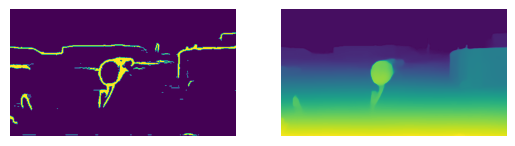

In [5]:
image_util.image_show(edge_map, depth_map, idx=(1,2))